In [1]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# (1) https://www.sciencedirect.com/science/article/pii/S0968432822000245 
# (2) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold

## Hertz and JKR functions

In [3]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

#Johnson-Kendall-Roberts model for indentation
#(3) https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    # JKR force formula in (3)
    force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

## Parameter definition

In [28]:
# resolution of the map
res = 20
# random values
size = res * res
# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
E = np.random.normal(loc=1.0, scale=0.3, size=size)
# Poisson's ratio 
nu = 0.5
# surface energy
    #gamma in (3) is given in J sub-units(???), but gamma <> Ua
gamma = 0.1
# radius of the indenter
r = 1.0

(array([ 6.,  6.,  9., 12., 20., 22., 31., 42., 34., 25., 45., 32., 41.,
        21., 18., 16., 11.,  3.,  3.,  3.]),
 array([0.2971655 , 0.37426405, 0.4513626 , 0.52846115, 0.6055597 ,
        0.68265825, 0.7597568 , 0.83685535, 0.9139539 , 0.99105245,
        1.068151  , 1.14524955, 1.2223481 , 1.29944665, 1.3765452 ,
        1.45364375, 1.5307423 , 1.60784086, 1.68493941, 1.76203796,
        1.83913651]),
 <BarContainer object of 20 artists>)

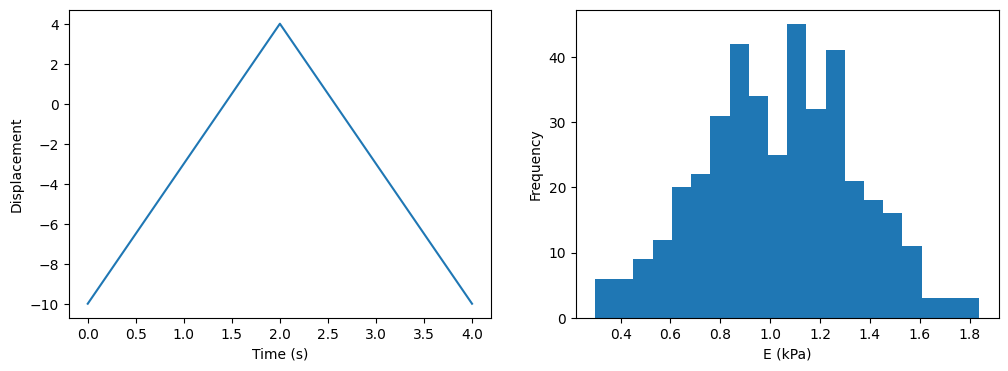

In [81]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-10, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 4, 20

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Displacement')
ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')
ax2.hist(E, 20)

## Initial df

In [115]:
# construct dataframe
df = pd.DataFrame()
# 'E' array to list:
df['E'] = E.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)


C:\Users\luisr\AppData\Local\Temp\ipykernel_9528\3838886906.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_9528\3838886906.py:54: RuntimeWarning: invalid value encountered in power
  force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75


## Initial df - plots

(4.7, -10.7, -0.8915941088839141, 18.66854518953644)

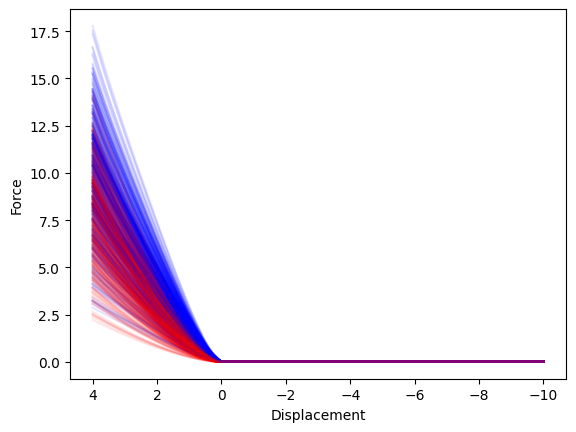

In [116]:
# plot all entries naively
# i: row index; row: data of each row in series format
for i, row in df.iterrows():
    #alpha: transparecy
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
#add labels
plt.xlabel('Displacement')
plt.ylabel('Force')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

C:\Users\luisr\AppData\Local\Temp\ipykernel_9528\3593840353.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
C:\Users\luisr\AppData\Local\Temp\ipykernel_9528\3593840353.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')


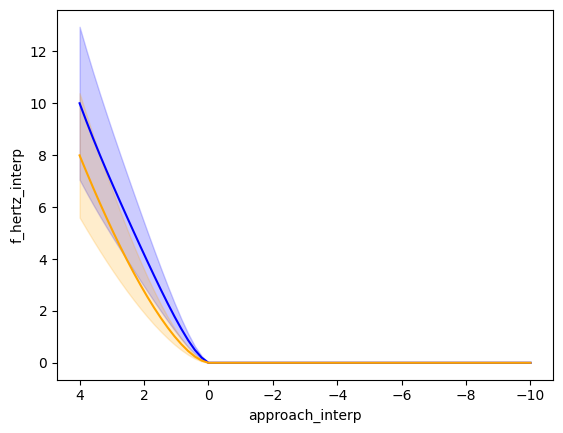

In [117]:
# plot all entries with seaborn
    # set_index: sets 'E' as the index (so the right value o E is assigned to the correct rows after the explode)
    # Series.explode: 'explodes' the arrays (disp and force) into different rows (scalars in each cell instead of arrays)
    # reset_index: because E is no longer needed as an index
df2 = df.set_index(['E']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue')
ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'orange')
ax.invert_xaxis()

## Initial df - Mapping E

<AxesSubplot: >

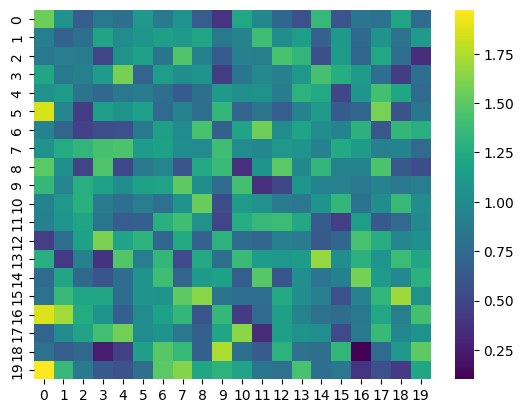

In [8]:
# map random values to a 2D array
#transforms E from array to matrix
E_map = np.reshape(E, (res, res))
# Young's modulus random map
sns.heatmap(E_map, cmap='viridis')
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

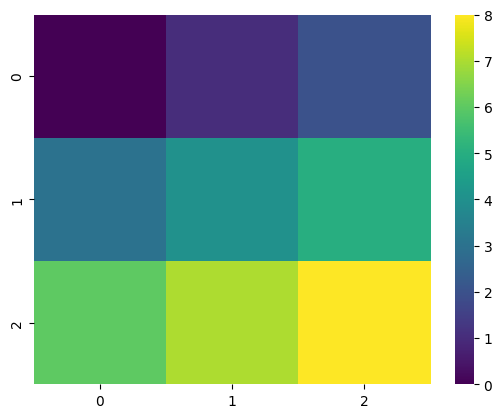

In [9]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.

# **HERTZ**

In [10]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>=0])
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact)-1:])
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape)

(20,) (20,)


### Inputs and labels

In [11]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
# check array dimensions
print(x_hc.shape, y_hc.shape)

(400, 2) (400,)


### Splitting with train_test_split()

(array([1., 3., 3., 3., 5., 6., 9., 6., 7., 5., 9., 7., 6., 3., 3., 7., 0.,
        1., 0., 3.]),
 array([0.35160787, 0.42069548, 0.48978309, 0.5588707 , 0.62795832,
        0.69704593, 0.76613354, 0.83522115, 0.90430877, 0.97339638,
        1.04248399, 1.1115716 , 1.18065922, 1.24974683, 1.31883444,
        1.38792206, 1.45700967, 1.52609728, 1.59518489, 1.66427251,
        1.73336012]),
 <BarContainer object of 20 artists>)

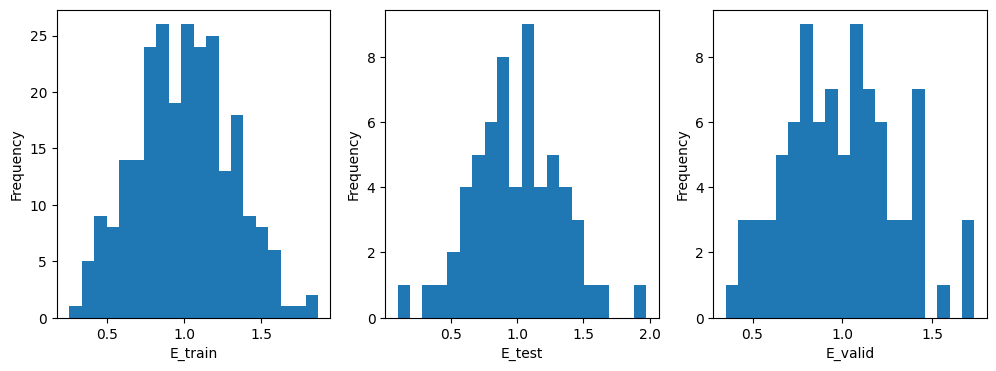

In [118]:
test_ratio = 0.15
# (!!!) validation ratio is currently given in relation to the entire dataset (!!!!)
valid_ratio = 0.3 
rnd_state = None

# Without stratify
#x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state)

#With stratify
bin_count = 20
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio*(1-test_ratio),
                                                       random_state=rnd_state, stratify = bins)


fig, (ax3, ax4, ax5) = plt.subplots(1,3, figsize=(12,4))
plt.ylabel('Frequency')
ax3.set_xlabel('E_train')
ax4.set_xlabel('E_test')
ax5.set_xlabel('E_valid')
for i in (ax3, ax4, ax5):
    i.set_ylabel('Frequency')
ax3.hist(y_train, 20)
ax4.hist(y_test, 20)
ax5.hist(y_valid, 20)


### Splitting with KFold

In [13]:
#skf = KFold(n_splits=2, shuffle=True, random_state=20)
#skf.get_n_splits(x_hc, y_hc)

#for i, (train_index, test_index) in enumerate(skf.split(x_hc, y_hc)):
#    print(f"Fold {i}:")
#   print(f"  Train: index={train_index}")
#  print(f"  Test:  index={test_index}")

#A, B = skf.split(x_hc, y_hc)

#fig, (ax5, ax6) = plt.subplots(1,2, figsize=(12,4))
#ax5.set_xlabel('E_fold1')
#ax5.hist(y_hc[B[0]], 20)
#ax6.set_xlabel('E_fold2')
#ax6.hist(y_hc[B[1]], 20)
